# Project: Write A Data Science Blog

## Project descrition

This project try to analyze the Airbnb dataset from Seattle to understand the listing price patterns and to make price predictions for a listing. The results we can draw from the analysis should support the pricing strategy for Airbnb listing in Seattle. 

Explornatory data analysis are made to firstly understand the listing price distribution based on temporal and locational facts, and wether the review scores have a effect on the price.

User behavior is analysis for how often they review on the same listing, which reflects how often the users come back to a listing they visited before. 

A regression model is trained using the dataset, the coefficients of the model are analyzed to define the important features that affect the price of the listing.

Due to the fact that the prices of different listing room types (entire apt/ private room/ shared room) should not be compared together, i trained model for each type. From the coefficients of the models we can see that the important features for each type are different.

##### There are 4 questions  i try to answer by applying data science analysis:
1. Are there areas in Seattle, that have more listings than other areas?
2. Are there areas in Seattle, that the price of listings are higher than other areas?
3. Which months in the year do more turists visit Seattle? How do the prices of the listing react on that?
4. How do the review scores effect on the listings? 
5. Do users tend to visit the same listing again?
6. Which features of a listing have effects on the listing price?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import geopandas as gpd
from shapely.geometry import mapping, shape, LineString, MultiPoint, Point
import mplleaflet
import seaborn as sns
%matplotlib inline


sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")


#df_listing.head()

## Load data, check data summary, preliminarily clean data

In [2]:
df_listing = pd.read_csv('./seattle/listings.csv')
df_calendar = pd.read_csv('./seattle/calendar.csv')
df_review = pd.read_csv('./seattle/reviews.csv')
df_review.head()

df_calendar.head()
df_listing.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [3]:
print(df_listing['availability_365'].describe())
print(df_listing['accommodates'].describe())
print(df_listing.groupby(['room_type']).mean()['availability_365'])

count    3818.000000
mean      244.772656
std       126.772526
min         0.000000
25%       124.000000
50%       308.000000
75%       360.000000
max       365.000000
Name: availability_365, dtype: float64
count    3818.000000
mean        3.349398
std         1.977599
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64
room_type
Entire home/apt    233.457300
Private room       264.280172
Shared room        297.111111
Name: availability_365, dtype: float64



#### Convert price from string to float


In [4]:
def price_str2num(df, price_col='price'):
    '''
    INPUT
    df - pandas DataFrame 
    
    OUTPUT
    df - pandas DataFrame
    the price column is converted from str to float
    '''
    
    df[price_col] = df[price_col].replace('[\$,]', '', regex=True).astype(float)

    return df

In [5]:
df_listing = price_str2num(df_listing, price_col='price')
df_calendar = price_str2num(df_calendar, price_col='price')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Summary: count of listings of three room types
room_type
Entire home/apt    2541
Private room       1160
Shared room         117

#### Combine the listings with reviews for later analysing the review bahavior of users, and distribution of listing reviews in three groups of listings by listing room_type, the count of each type

In [6]:
df_listing_zip = df_listing[['id', 'zipcode', 'longitude', 'latitude', 'room_type', 'neighbourhood_group_cleansed']]
df_listing_zip = df_listing_zip.rename(columns={'id':'listing_id'})
df_listing_review = df_listing_zip.set_index('listing_id').join(df_review.set_index('listing_id'))
print(df_listing_review.groupby(['room_type']).count()['id'])

room_type
Entire home/apt    52465
Private room       30870
Shared room         1514
Name: id, dtype: int64


#### Combine the listing with the calendar data
##### Canlendar data is converted to datetime for further temporal analysis

In [7]:
df_listing_zip = df_listing[['id', 'zipcode', 'longitude', 'latitude', 'room_type', 'neighbourhood_group_cleansed']]
calendar_clean = df_calendar.dropna()
calendar_clean.set_index("date", inplace = True)
calendar_clean.index = pd.to_datetime(calendar_clean.index)
calendar_clean.index = pd.to_datetime(calendar_clean.index)
calendar_clean['month']= calendar_clean.index.month
calendar_clean = calendar_clean.loc[calendar_clean['available']=='t']
df_listing_calendar = df_listing_zip.set_index('id').join(calendar_clean.set_index('listing_id'))

df_listing_calendar.dropna(inplace=True)

print(df_listing_calendar.groupby(['room_type']).count()['price'])
df_listing_calendar.head(5)

C:\Users\FIXCV8D\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


room_type
Entire home/apt    592695
Private room       305833
Shared room         34762
Name: price, dtype: int64


,zipcode,longitude,latitude,room_type,neighbourhood_group_cleansed,available,price,month
3335,98118,-122.27584,47.529846,Entire home/apt,Rainier Valley,t,120.0,2.0
3335,98118,-122.27584,47.529846,Entire home/apt,Rainier Valley,t,120.0,3.0
3335,98118,-122.27584,47.529846,Entire home/apt,Rainier Valley,t,120.0,3.0
3335,98118,-122.27584,47.529846,Entire home/apt,Rainier Valley,t,120.0,3.0
3335,98118,-122.27584,47.529846,Entire home/apt,Rainier Valley,t,120.0,3.0


In [8]:
34762/117
305833/1160
592695/2541

233.25265643447463

# Exploratery Data Analysis on listing review

Analyse the review behavior of users, how many reviews a particular user made, how often the same user make reviews on the same listing

In [9]:
df_review_l = df_review.groupby(['reviewer_id']).count()
df_review_l = df_review_l.sort_values(['comments'], ascending=False)
#sns.swarmplot(x=df_review_l.index.values,y='comments', data=df_review_l)
#df_review_l.describe()
df_review_l.head(5)

,listing_id,id,date,reviewer_name,comments
reviewer_id,,,,,
206203,67,67,67,67,67
15121499,32,32,32,32,32
5775807,19,19,19,19,19
2734499,19,19,19,19,19
29590276,18,18,18,18,18


In [10]:
#df_review_lm = df_review_l.loc[df_review_l['comments']>2]
#df_review_lm['neighbourhood_group_cleansed'].unique()
#df_review_lm.sort_values(['comments'], ascending=False).plot(marker='*', linestyle='none')

In [11]:
#sns.swarmplot(x=df_review_lm['comments'])

In [12]:
df_review_lmc = df_review_l.reset_index()
df_review_lmc.head()
#df_review_lm['id'].plot()

,reviewer_id,listing_id,id,date,reviewer_name,comments
0,206203,67,67,67,67,67
1,15121499,32,32,32,32,32
2,5775807,19,19,19,19,19
3,2734499,19,19,19,19,19
4,29590276,18,18,18,18,18


#### How many reviews each user made

In [13]:
df_review_lmc_pivot = pd.pivot_table(df_review_lmc, columns='comments', values='id', aggfunc='count')
df_review_lmc_pivot = pd.DataFrame(df_review_lmc_pivot.stack().reset_index())
df_review_lmc_pivot = df_review_lmc_pivot.rename(columns={0:'comments_count'})
df_review_lmc_pivot

,level_0,comments,comments_count
0,id,0,13
1,id,1,69372
2,id,2,4929
3,id,3,877
4,id,4,270
5,id,5,109
6,id,6,66
7,id,7,36
8,id,8,13
9,id,9,14


#### The description of number of the reviews from the same user

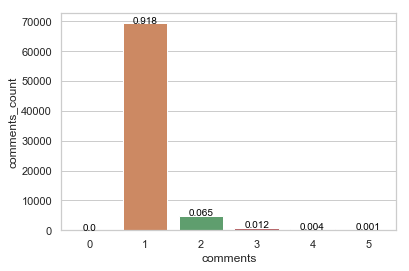

In [14]:
df_review_count = df_review_lmc_pivot.loc[df_review_lmc_pivot['comments']<6]
g = sns.barplot(x='comments', y='comments_count', data=df_review_count)

for index, row in df_review_count.iterrows():
    g.text(row.comments,row.comments_count, round(row.comments_count/sum(df_review_count.comments_count), 3), color='black', ha="center")

plt.show()

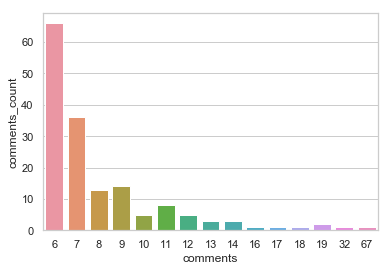

In [15]:
df_review_count = df_review_lmc_pivot.loc[df_review_lmc_pivot['comments']>5]
g = sns.barplot(x='comments', y='comments_count', data=df_review_count)

plt.show()

#### How many users make multiple reviews on the same listing? which shows how often a user visit the listing again for how many times

In [16]:
df_review_c = df_review.groupby(['listing_id', 'reviewer_id']).count()
#df_review_c.sort_values(['comments'], ascending=False)

In [17]:
df_review_multi = df_review_c

In [18]:
#df_review_multi

In [19]:
df_review_multi_pivot = pd.pivot_table(df_review_multi, columns='comments', values='id', aggfunc='count')
df_review_multi_pivot = pd.DataFrame(df_review_multi_pivot.stack().reset_index())
df_review_multi_pivot = df_review_multi_pivot.rename(columns={0:'comments_count'})
df_review_multi_pivot

,level_0,comments,comments_count
0,id,0,16
1,id,1,82435
2,id,2,950
3,id,3,92
4,id,4,23
5,id,5,11
6,id,6,1
7,id,7,3
8,id,8,3
9,id,11,2


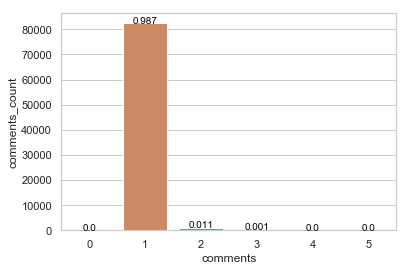

In [20]:
df_review_repeat_count = df_review_multi_pivot.loc[df_review_multi_pivot['comments']<6]
g2 = sns.barplot(x='comments', y='comments_count', data=df_review_repeat_count)
for index, row in df_review_repeat_count.iterrows():
    g2.text(row.comments,row.comments_count, round(row.comments_count/sum(df_review_repeat_count.comments_count), 3), color='black', ha="center")

plt.show()

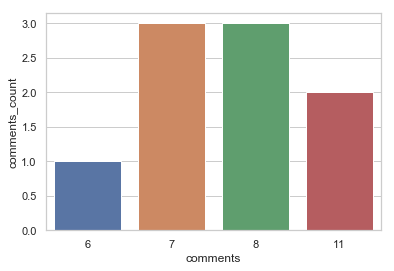

In [21]:
df_review_repeat_count = df_review_multi_pivot.loc[df_review_multi_pivot['comments']>5]
g2 = sns.barplot(x='comments', y='comments_count', data=df_review_repeat_count)

plt.show()

#### Create GeoDataFrame to analyse distribution of listings based on their locations

In [22]:
def geo_df(df, lon, lat):
    '''
    INPUT
    df - pandas dataframe contains coordinates
    lon - column name of longititude
    lat - column name of latitude
    
    OUTPUT
    gdf - a GeoDataframe created from df
    '''
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(df[lon], df[lat]))
    gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates')
    
    return gdf

In [23]:
gdf_listing = geo_df(df_listing, 'longitude', 'latitude')
#gdf_listing.plot(column='price', cmap='Reds')

In [24]:
gdf_listing['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

# Exploratery Data Analysis  

### Plot the features of the listings to provide some insight into the descriptive statistics of the data.

In [25]:
def feature_swarmplot(df_listing, room_type='Entire home/apt', var_toplot='review_scores_value'):
    '''
    This function drow the swarmplot of the dataframe 
    input: 
    df_listing: the dataFrame with listings
    room_type: the listing with the room_type to be plotted
    var_toplot: the X axis to plot
    '''
    df_listing_apt = df_listing.loc[df_listing['room_type']==room_type].sort_index()
    #df_listing_apt = df_listing.loc[df_listing['room_type']=='Private room'].sort_values(['price'], ascending=False)
    plt.figure(figsize=(18, 9))
    chart = sns.swarmplot(x=var_toplot,y='price', data=df_listing_apt, alpha=0.8)
    sns.boxplot(x=var_toplot,y='price', data=df_listing_apt, whis=np.inf, boxprops=dict(alpha=.3))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
    #chart.set_yticklabels(chart.get_yticklabels(), fontsize=12)
    chart.set_xlabel(var_toplot,fontsize=20)
    chart.set_ylabel('Price',fontsize=20)

    pass
#sns.swarmplot(x='zipcode',y='price', data=df_listing_apt)

#### The distribution of listings in each neighbourhood, three room types are plotted

C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


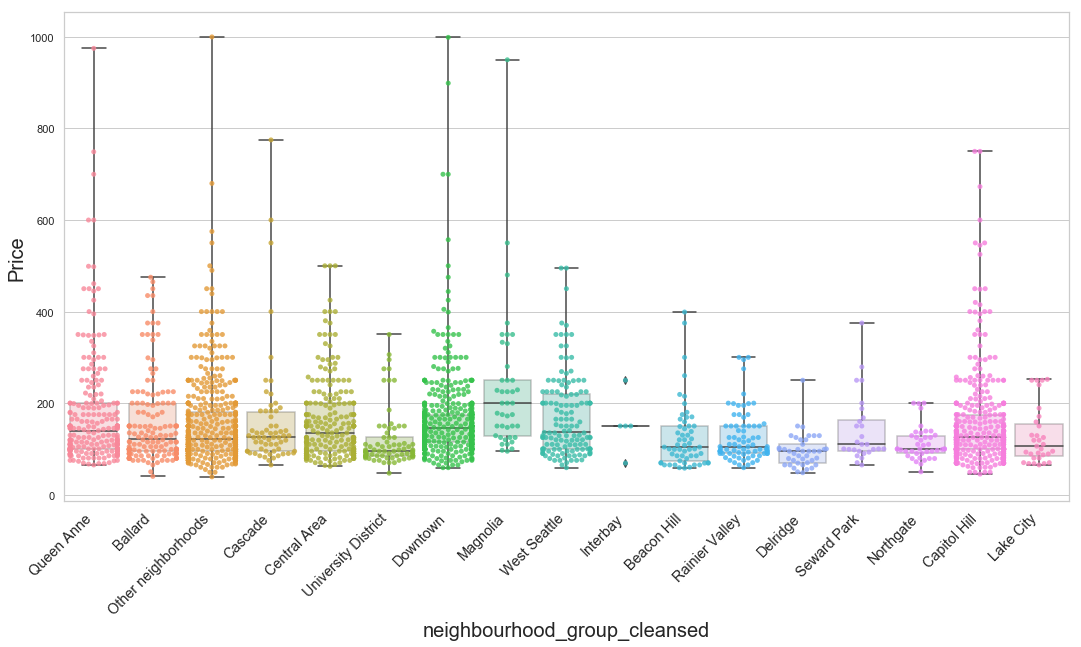

In [26]:
feature_swarmplot(df_listing, room_type='Entire home/apt', var_toplot='neighbourhood_group_cleansed')

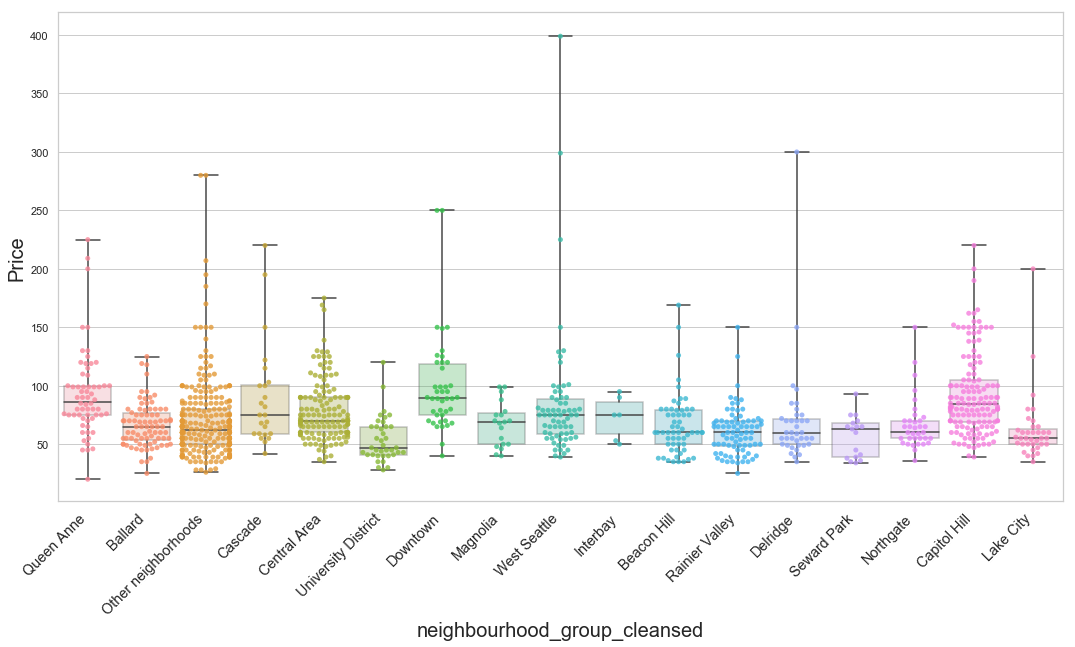

In [27]:
feature_swarmplot(df_listing, room_type='Private room', var_toplot='neighbourhood_group_cleansed')

C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


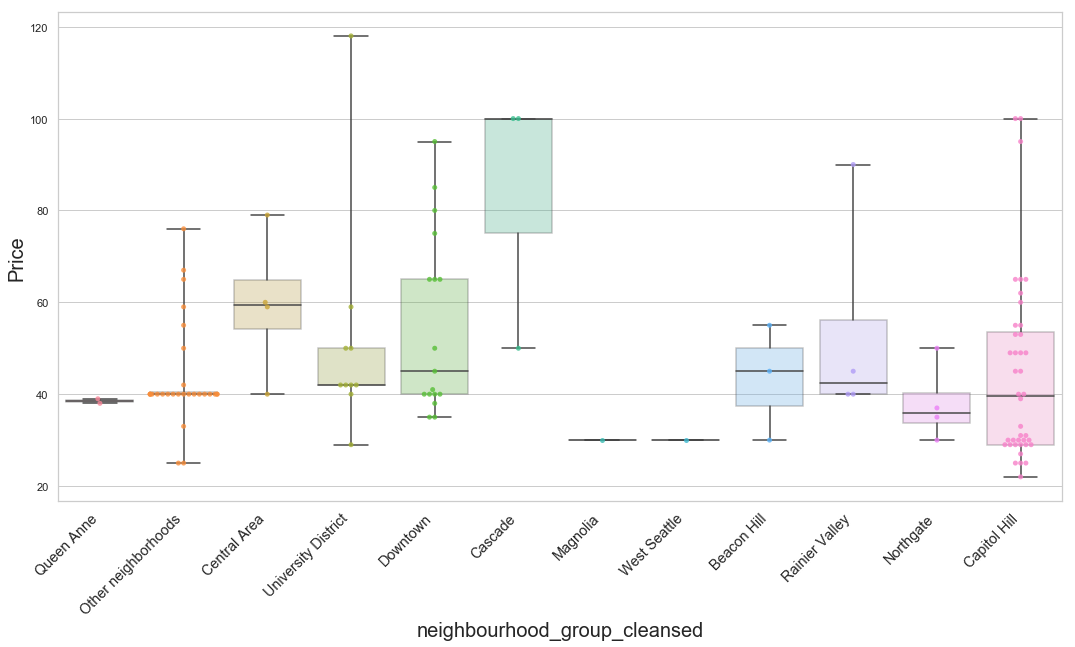

In [28]:
feature_swarmplot(df_listing, room_type='Shared room', var_toplot='neighbourhood_group_cleansed')

#### The distribution of listings according to their review scores

C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


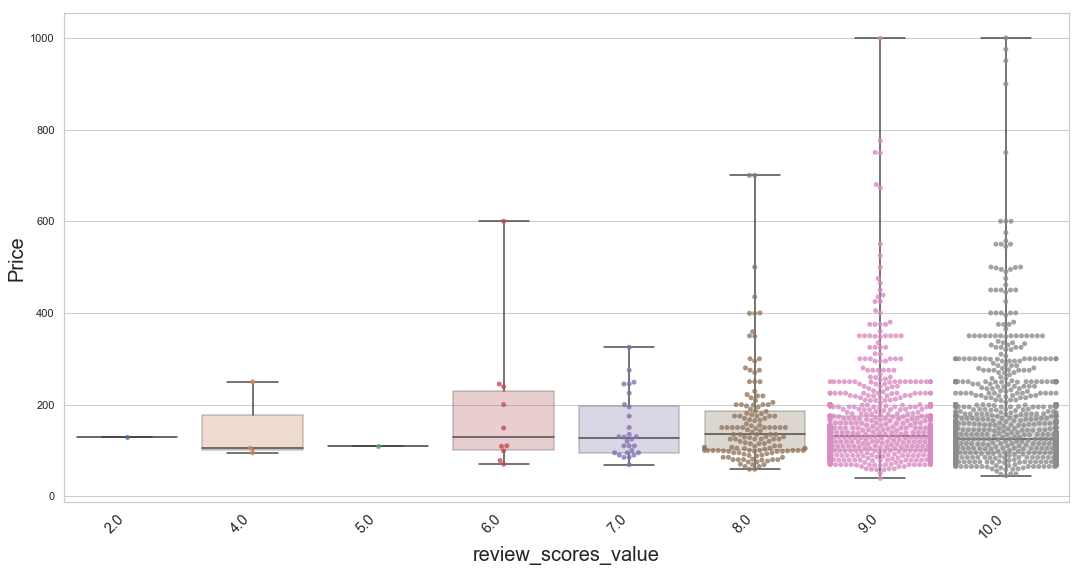

In [29]:
feature_swarmplot(df_listing, room_type='Entire home/apt', var_toplot='review_scores_value')


C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


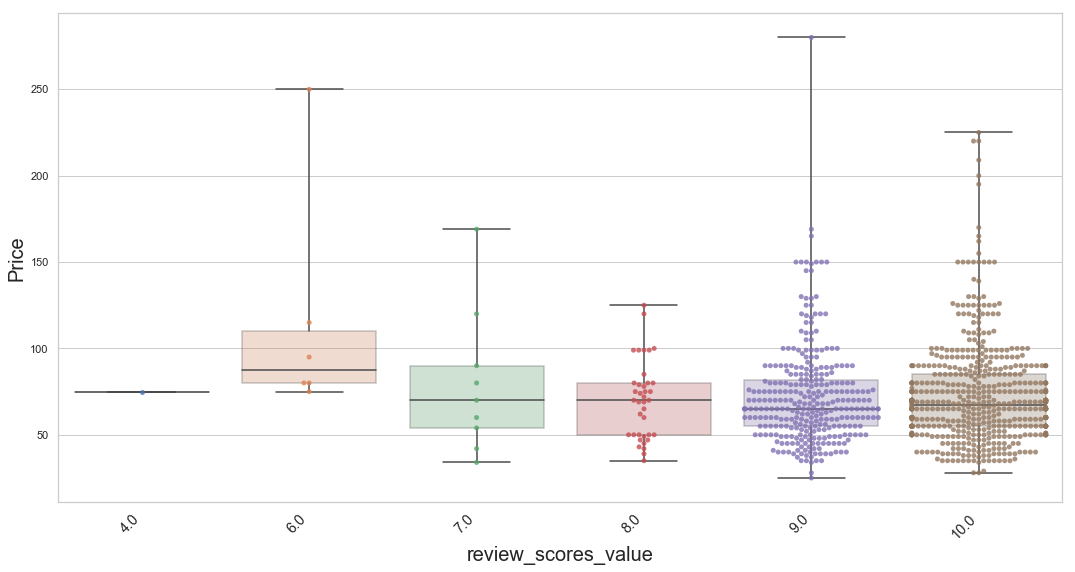

In [30]:
feature_swarmplot(df_listing, room_type='Private room', var_toplot='review_scores_value')


C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\FIXCV8D\AppData\Local\conda\conda\envs\ProfileLearning\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


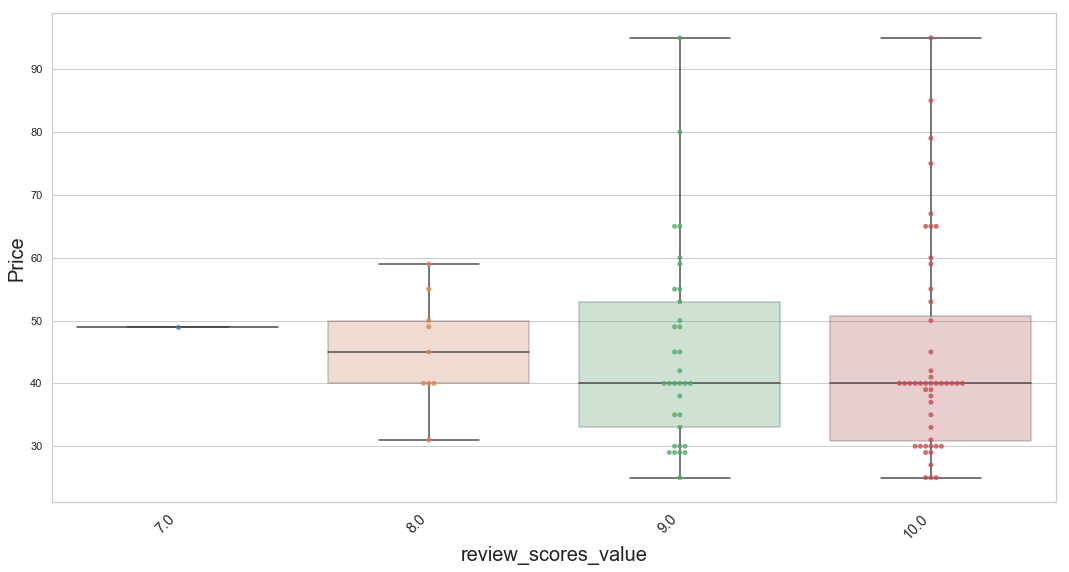

In [31]:
feature_swarmplot(df_listing, room_type='Shared room', var_toplot='review_scores_value')


#### Plot the price distribution for each room type

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

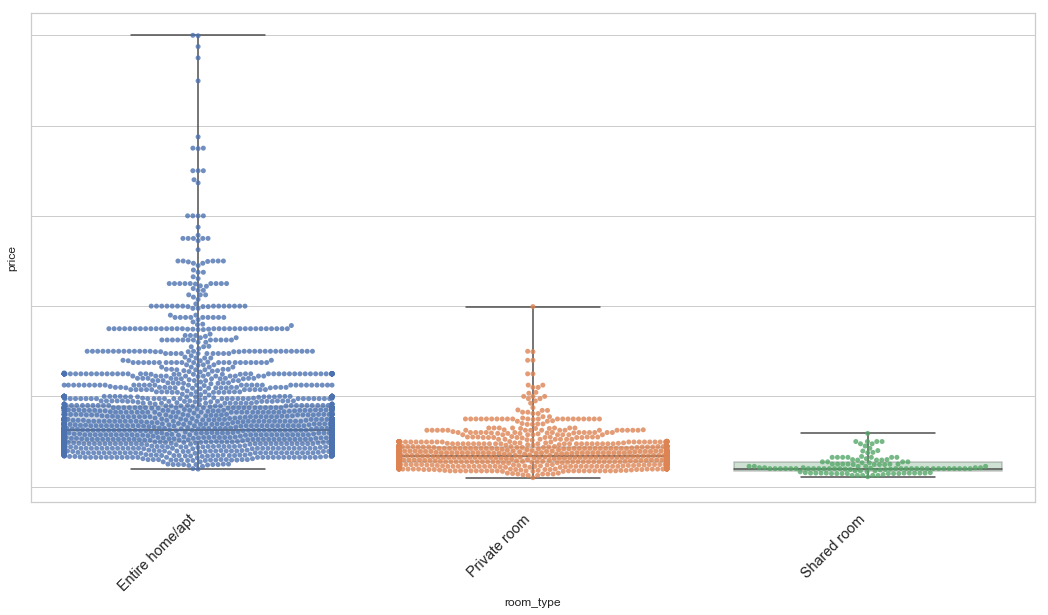

In [32]:
plt.figure(figsize=(18, 9))   
chart = sns.swarmplot(x='room_type',y='price', data=df_listing, alpha=0.8)
b = sns.boxplot(x='room_type',y='price', data=df_listing, whis=np.inf, boxprops=dict(alpha=.3))
chart.set_xticklabels(chart.get_xticklabels(),rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
chart.set_yticklabels(chart.get_yticklabels(), fontweight='light', fontsize='x-large')

In [33]:
gdf_listing_apt = gdf_listing.loc[gdf_listing['room_type']=='Entire home/apt']
gdf_listing_room = gdf_listing.loc[gdf_listing['room_type']=='Private room']
gdf_listing_shared = gdf_listing.loc[gdf_listing['room_type']=='Shared room']
#gdf_listing_apt.plot(column='price', cmap='Reds')

In [34]:
gdf_listing_apt = gdf_listing_apt.groupby(['neighbourhood_group_cleansed']).mean()
#gdf_listing_apt.head()
gdf_listing_ave = geo_df(gdf_listing_apt, 'longitude', 'latitude')
gdf_listing_ave.price.describe()

#sns.swarmplot(x=gdf_listing_ave.index.values,y='price', data=gdf_listing_ave)

count     17.000000
mean     148.806479
std       30.968747
min       95.780488
25%      126.434211
50%      153.800000
75%      162.354839
max      232.390244
Name: price, dtype: float64

In [35]:
#gdf_listing_ave.plot(column='price', cmap='Reds')

## Analysis of listing count and price trend over time

#### monthly average listing count and price 
#### daily average listing count and price are calculated and indexed by months. 

In [36]:
df1  = df_calendar.groupby("date")[["price"]].sum()
df1["mean"]  = df_calendar.groupby("date")[["price"]].mean()
df1.columns = ["Total", "Average"]
df1.head()

,Total,Average
date,,
2016-01-04,211819.0,122.085879
2016-01-05,225312.0,120.681307
2016-01-06,220815.0,120.928258
2016-01-07,214823.0,120.958896
2016-01-08,227456.0,127.640853


In [37]:
df2 = df_calendar.set_index("date")
df2.index = pd.to_datetime(df2.index)
df2 =  df2[["price"]].resample("M").mean()
df2.head(2)

,price
date,
2016-01-31,121.568409
2016-02-29,124.293927


In [38]:

calendar_clean = df_calendar.dropna()
calendar_clean.set_index("date", inplace = True)
calendar_clean.index = pd.to_datetime(calendar_clean.index)
calendar_clean.index = pd.to_datetime(calendar_clean.index)
calendar_clean['month']= calendar_clean.index.month
calendar_clean_m = calendar_clean
calendar_clean_m['room_count'] =  calendar_clean[["price"]].resample("D").count()
calendar_clean_m['price_ave'] =  calendar_clean[["price"]].resample("D").mean()

C:\Users\FIXCV8D\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\FIXCV8D\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\FIXCV8D\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

#### plot of average monthly price over the year

,listing_id,available,price,month,room_count,price_ave
date,,,,,,
2016-01-04,241032,t,85.0,1,1735,122.085879
2016-01-05,241032,t,85.0,1,1867,120.681307


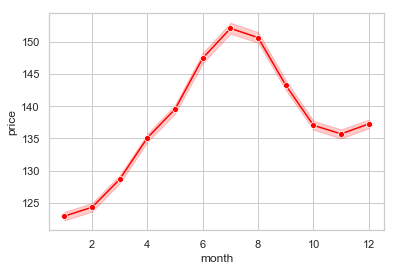

In [39]:
sns.set_style("whitegrid")
sns.lineplot(x='month', y='price', marker='o', color='red', data=calendar_clean)
calendar_clean.head(2)

#### plot of average listing count over the year

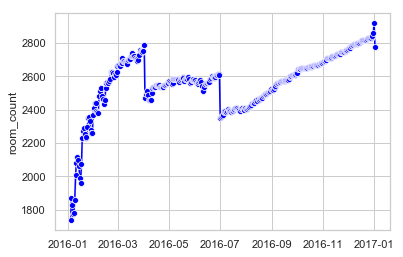

In [40]:
sns.lineplot(x=calendar_clean_m.index.values, y='room_count', marker='o', color='blue', data=calendar_clean_m)#sns.lineplot(x=calendar_clean.index.values, y=calendar_clean['room_count'], marker='o', c='blue')

#### Plot of daily average price over the year

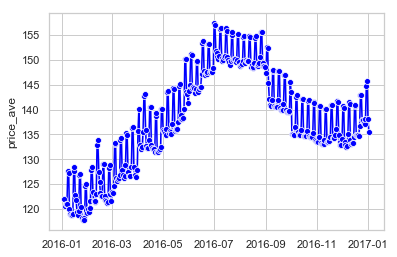

In [41]:
sns.lineplot(x=calendar_clean_m.index.values, y='price_ave', marker='o', color='blue', data=calendar_clean_m)#sns.lineplot(x=calendar_clean.index.values, y=calendar_clean['room_count'], marker='o', c='blue')

#### Plots of average price and count of listings for each neighbourhoods over the year

In [42]:
#gdf_listing_calendar = df_listing_calendar
gdf_listing_calendar = df_listing_calendar.groupby(['month', 'neighbourhood_group_cleansed'])[['price']].count().rename(columns={'price':'room_count'})
gdf_listing_calendar = gdf_listing_calendar.join(df_listing_calendar.groupby(['month', 'neighbourhood_group_cleansed'])[['price']].mean().rename(columns={'price':'price_ave'}), how='outer')
gdf_listing_calendar = gdf_listing_calendar.join(df_listing_calendar.groupby(['month', 'neighbourhood_group_cleansed'])[['longitude']].mean(), how='outer')
gdf_listing_calendar = gdf_listing_calendar.join(df_listing_calendar.groupby(['month', 'neighbourhood_group_cleansed'])[['latitude']].mean(), how='outer')
gdf_listing_calendar.head()

room_count   price_ave   longitude  \
month neighbourhood_group_cleansed                                       
1.0   Ballard                             3663  108.826645 -122.380895   
      Beacon Hill                         2110   97.777725 -122.304845   
      Capitol Hill                        9233  123.087187 -122.315938   
      Cascade                             1222  139.289689 -122.331466   
      Central Area                        5862  120.848516 -122.301983   

                                     latitude  
month neighbourhood_group_cleansed             
1.0   Ballard                       47.674560  
      Beacon Hill                   47.567788  
      Capitol Hill                  47.623536  
      Cascade                       47.634683  
      Central Area                  47.608154

In [43]:
gdf_listing_calendar_pivot = gdf_listing_calendar.reset_index()
gdf_listing_calendar_pivot = gdf_listing_calendar_pivot.pivot(index='month', columns='neighbourhood_group_cleansed', values='room_count')
gdf_listing_calendar_pivot.head()


neighbourhood_group_cleansed,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle
month,,,,,,,,,,,,,,,,,
1.0,3663,2110,9233,1222,5862,1450,9484,245,1361,1362,1308,13262,4496,2721,849,2544,3633
2.0,4069,2371,10319,1438,6985,1724,10869,257,1416,1438,1557,14622,5152,3185,978,2719,4111
3.0,4850,2740,11603,1754,7868,1888,12279,279,1665,1529,1930,17047,5783,3754,1138,2989,4712
4.0,4587,2551,10409,1534,7070,1799,11013,241,1582,1366,1777,15811,5144,3218,906,2636,4276
5.0,4985,2696,10987,1636,7577,1872,11203,246,1651,1446,1936,16814,5341,3266,940,2818,4444


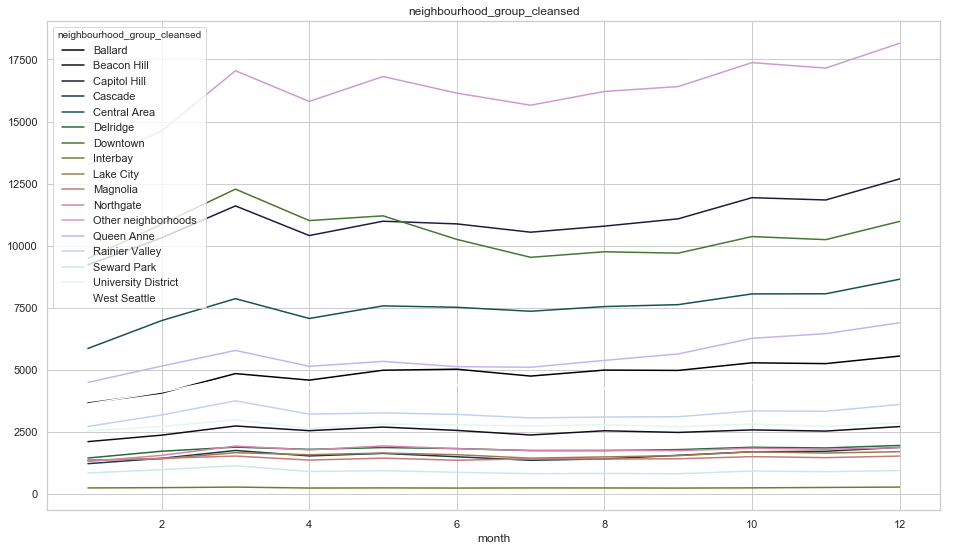

In [44]:
gdf_listing_calendar_pivot.plot(figsize=(16, 9), title='neighbourhood_group_cleansed', colormap='cubehelix');
#sns.lineplot(x='month', y='room_count', marker='o', color='red', data=calendar_clean, linewidth=2)

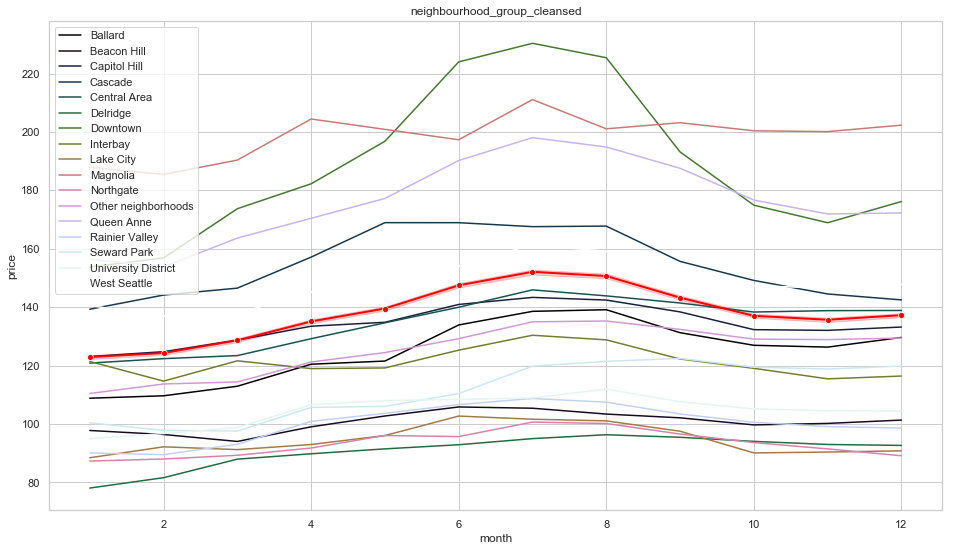

In [45]:
gdf_listing_calendar_pivot2 = gdf_listing_calendar.reset_index()
gdf_listing_calendar_pivot2 = gdf_listing_calendar_pivot2.pivot(index='month', columns='neighbourhood_group_cleansed', values='price_ave')
gdf_listing_calendar_pivot2.head()
gdf_listing_calendar_pivot2.plot(figsize=(16, 9), title='neighbourhood_group_cleansed', colormap='cubehelix');

sns.lineplot(x='month', y='price', marker='o', color='red', data=calendar_clean, linewidth=2)


#### Heat maps of distribution of average prices/ listing counts of neighbourhoods on map

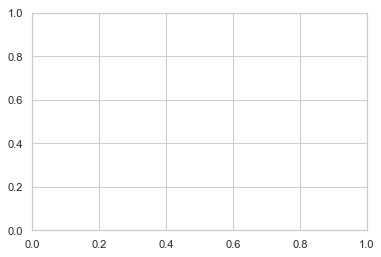

In [46]:
gdf_listing_calendar_w = geo_df(gdf_listing_calendar, 'longitude', 'latitude')
fig, ax = plt.subplots()

ax = gdf_listing_calendar_w.xs(7.0).plot(figsize=(16, 9), column='price_ave', cmap='Reds', markersize=120, edgecolor='black')
price_list = list(gdf_listing_calendar_w.xs(7.0)['price_ave'])

for x, y, label in zip(gdf_listing_calendar_w.xs(7.0).geometry.x, gdf_listing_calendar_w.xs(7.0).geometry.y, gdf_listing_calendar_w.xs(7.0).index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

mplleaflet.display(fig = ax.figure)

In [47]:
gdf_listing_calendar_w = geo_df(gdf_listing_calendar, 'longitude', 'latitude')
gdf_listing_calendar_w.xs(7.0).plot(figsize=(16, 9), column='room_count', cmap='Purples', markersize=120, edgecolor='black')

mplleaflet.display()

In [48]:
df_listing.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


## Price Prediction

### This section clean the data and prepare the training and testing datasets to train a regression model to predict the price of a listing. 

#### Models are trained for each room type.

#### the coefficients of the model are analyzed to define the important features that affect the price of the listing.

In [49]:
def rate_str2num(df, rate_col='price'):
    '''
    INPUT
    df - pandas DataFrame 
    
    OUTPUT
    df - pandas DataFrame
    the rate column is converted from str to float
    '''
    
    df[rate_col] = df[rate_col].replace('[\%,]', '', regex=True).astype(float)

    return df

In [50]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variabl    
    
    '''
    df = price_str2num(df, price_col='price')
    df = price_str2num(df, price_col='weekly_price')
    df = price_str2num(df, price_col='monthly_price')
    df = price_str2num(df, price_col='cleaning_fee')
    df = price_str2num(df, price_col='security_deposit')
    df = rate_str2num(df, rate_col='host_acceptance_rate')
    df = rate_str2num(df, rate_col='host_response_rate')
    
    # Drop rows with missing price values
    df.dropna(subset=['price'], axis=0, inplace=True)
    
    #Drop columns with a constant value
    df = df.drop(['last_scraped', 'scrape_id', 'jurisdiction_names', 'longitude', 'latitude', 'id', 'host_id', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'weekly_price', 'monthly_price'], axis=1)
    
    # Drop empty rows
    df.dropna(how='all', axis=1, inplace=True)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['int', 'float', 'int64']).copy().columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    # find the categorical columns, separate them into dummy or too many unique values   
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    nondummy_var = []
    dummy_var = []
    for col in cat_vars:
        if len(df[col].unique())>6:
            nondummy_var += [col]
        else:
            dummy_var += [col]
    print(df.shape)       
    for var in nondummy_var:
        #df[var] = pd.isnull(df[var])
        df = pd.concat([df.drop(var, axis=1), pd.isnull(df[var])], axis=1)
        
    print(df.shape)
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=False)], axis=1)
    print(df.shape)

    return df

In [51]:
def train_model(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X_train - A matrix holding all of the variables you want to consider when predicting the response
    y_train - the corresponding response vector
    X_test - 
    y_test - 
    '''
    
    #Split into explanatory and response variables
    y = df['price']
    X = df.drop(['price'], axis=1)
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
    print(X_train.shape, X_test.shape[0])
    lm_model = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=100)# Instantiate
    print(lm_model)
    lm_model = lm_model.fit(X_train, y_train) #Fit
    print(lm_model)
        
    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 

    #Rsquared and y_test
    test_score = r2_score(y_test, y_test_preds)#r2_score
    train_score = lm_model.score(X_train,y_train)
    length_y_test = y_test.shape[0]#num in y_test
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test
    

In [52]:
def coef_weights(coefficients, X_train, lm_model):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.feature_importances_
    coefs_df['abs_coefs'] = np.abs(lm_model.feature_importances_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df



In [53]:
def RF_regress(df, room_type='Entire home/apt'):
    df_listing_apt = df.loc[df['room_type']==room_type].sort_index()
    df_listing_clean = clean_data(df_listing_apt)
    test_score, train_score, lm_model, X_train, X_test, y_train, y_test = train_model(df_listing_clean)

    #Use the function
    coef_df = coef_weights(lm_model.feature_importances_, X_train, lm_model)

    #A quick look at the top results
    print(coef_df.head(20))
    print(test_score, train_score)

In [54]:
RF_regress(df_listing, room_type='Entire home/apt')

(2541, 76)
(2541, 76)
(2541, 112)
(1778, 111) 763
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
                                  

In [55]:
RF_regress(df_listing, room_type='Private room')

(1160, 76)
(1160, 76)
(1160, 107)
(812, 106) 348
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
                              est_i

In [56]:
RF_regress(df_listing, room_type='Shared room')

(117, 75)
(117, 75)
(117, 105)
(81, 104) 36
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
                           est_int     c

In [57]:
roc_auc_score(y_test, lm_model.predict_proba(X_test)[:,1])

NameError: name 'y_test' is not defined

In [ ]:
df_listing_clean = clean_data(df_listing)
df_listing_clean.head()

In [ ]:
cat_vars = df_listing.select_dtypes(include=['object']).copy().columns
num_vars = df_listing.select_dtypes(include=['int', 'float', 'int64']).copy().columns
cat_vars2 = df_listing.select_dtypes(exclude=['int', 'float', 'object','int64']).copy().columns
print(len(cat_vars), cat_vars)
print(len(num_vars), num_vars)
print(len(cat_vars2), cat_vars2)

nondummy_var = []
dummy_var = []
for col in cat_vars:
    if len(df_listing[col].unique())>10:
        nondummy_var += [col]
    else:
        dummy_var += [col]    

print(nondummy_var, dummy_var)

df_listing_clean.columns.values

type(df_listing['host_id'][1])
        
dummy_vars = ['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification']
dummy_vars = ['listing_url', 'name', 'summary', 'space',
       'description', 
        'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 
       'host_location', 'host_about', 'host_response_time', 'experiences_offered'
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
        'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification']   
        
not_sure = ['last_scraped' 'host_since',   'neighborhood_overview', 'notes', 'street',
        'transit']
    

In [ ]:
df_listing = price_str2num(df_listing, price_col='weekly_price')
df_listing = price_str2num(df_listing, price_col='monthly_price')
df_listing = price_str2num(df_listing, price_col='cleaning_fee')

In [ ]:
df_listing[cat_vars].head()

In [ ]:
# Random Forest